In [1]:
import numpy as np
import time
from IPython import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 一个三体问题的第三方库

***

In [6]:
class TBP():
    # 一个计算三体问题的第三方库
    class entity:
        def __init__(self,r=1,rou=1,mess=100,coordinate=(0,0),velocity=(0,0)):
            self.r=r
            self.m=mess
            self.coor=np.array(coordinate)
            self.vel=np.array(velocity)
            self.rou=rou
        def position(self):
            return self.vel
        
    def __init__(self,G=10,num=3,dim=2,dt=0.01,poches=1,min_distance=5,method="直线预测",parameter=None,path=None):
        self.G=G
        self.dt=dt
        self.dim=dim
        self.num=num
        self.method=method
        self.poches=poches
        self.name_list=[str(i+1) for i in range(num)]
        self.min_distance=min_distance
        
        if type(parameter)==np.ndarray: # 通过读入参数初始化
            self.set_parameter(parameter)
        elif path != None:              # 通过文件参数初始化
            self.load_parameter(path)
        else:                           # 随机初始化
            self.random_parameter(num,dim)
        self.initreport()
        
    def set_parameter(self,parameter):
        shape=parameter.shape
        num=shape[0]
        dim=int((shape[1]-1)/2)
        self.dim=dim
        self.num=num
        self.entities=[self.entity() for i in range(num)]
        k=0
        for i in self.entities:
            i.r=parameter[k,0]
            i.m=parameter[k,1]
            i.coor=np.array(parameter[k,2:(2+dim)])
            i.vel=np.array(parameter[k,(2+dim):])
            i.rou=i.m/(4/3*np.pi*pow(i.r,3))
            k=k+1
    
    def load_parameter(self,path,dtype=np.float,delimiter=',',unpack=False):
        # 读取顺序 半径 质量 坐标*dim 速度*dim
        #
        parameter=np.loadtxt(path,dtype=dtype,delimiter=delimiter,unpack=unpack)
        shape=parameter.shape
        num=shape[0]
        dim=int((shape[1]-1)/2)
        self.dim=dim
        self.num=num
        self.entities=[self.entity() for i in range(num)]
        k=0
        for i in self.entities:
            i.r=parameter[k,0]
            i.m=parameter[k,1]
            i.coor=np.array(parameter[k,2:(2+dim)])
            i.vel=np.array(parameter[k,(2+dim):])
            i.rou=i.m/(4/3*np.pi*pow(i.r,3))
            k=k+1
            
    def random_parameter(self,num,dim):
        self.entities=[self.entity() for i in range(num)]
        for i in self.entities:
            i.r=np.random.randint(25,36,(1,))
            i.m=np.random.randint(1e8,2e8+1,(1,))
            i.coor=np.random.randint(-14e3,14e3+1,(dim,))
            i.vel=np.random.randint(-4e3,4e3+1,(dim,))
            i.rou=i.m/(4/3*np.pi*pow(i.r,3))

    def run(self,step=1,times=1,process_display=True,image_display=True):
        dt=self.dt
        method=self.method
        #print("test  ",dt," ",method)
        start_time=time.time()
        if image_display == True:
            process_display=False
        for p in range(times):
            if type(method)==str:
                if method == "simple":
                    self.simple_step()
                elif method=="直线预测":
                    self.line_step()
                elif method=="中心差商":
                    Coor_before=np.zeros((self.num,self.dim))
                    for i in range(self.num):
                        Coor_before[i,:]=self.entities[i].coor
                    Coor_before=self.centre_step(Coor_before=Coor_before)
                elif method=="二次递推":
                    self.dou_step()
                else:
                    raise Exception('\033[1;33mMethod Not Found:\033[3;31m<method \'%s\'>'%self.method)
            else:
                raise Exception('\033[1;33mError Type:\033[3;31m<method \'%s\'>'%str(self.method)+'\033[1;33m type:\033[3;31m%s'%type(self.method))
            if process_display == True:
                self.step_info(p=p,times=times,start_time=start_time)
            if image_display == True:
                self.display()
    def initreport(self,):
        print("加载完成，本次模拟基础信息如下:\n")
        self.head(3)
        
    def step_info(self,p,times,start_str='',end_str='',total_length=40,start_time=0):
        percent=(p+1)/times
        n=int(percent * total_length)
        bar ='='*(n+1)
        bar = ('\r' + start_str + '  [' + bar.ljust(total_length) +
               "]  Percent:"+'<{:0>4.1f}%'.format(percent*100)+ '/100.0%>'+
               "  Process:<"+str(p+1)+'/'+str(times)+'>'+
               "  Time:<"+format(time.time()-start_time,'.2')+'s>')
        if p == 0:
            print("  Process:  <"+str(self.poches)+' Poches>')
        print(bar, end='', flush=True)
        if percent>=1:
            print('\n  complete.','\tTime:<'+format(time.time()-start_time,'.2')+'s>')
            print('_'*(total_length+62),end='\n')
            
    def head(self,n=10,state_only=False):
        if state_only != True:
            print("模拟信息:")
            print("  实体数量:",self.num,"\t时间步长",self.dt,"\tpoches:",self.poches,"\t求解方法:",self.method,end='\n')
            print("  空间维度:",self.dim,"\t引力常数:",self.G,end='\n\n')
        if n<0 or n>self.num:
            n=self.num
        print("实体信息:")
        for i in range(n):
            print("%d号实体参数如下:"%(i+1),"\n",
                  " 半径:"+format(int(self.entities[i].r),'.4e'),
                  "\t质量:"+format(int(self.entities[i].m),'.4e'),
                  "\t密度:"+format(int(self.entities[i].rou),'.4e'),
                  "\n  坐标:"+'['+','.join([format(k,'.4e') for k in list(self.entities[i].coor)])+']',
                  "\t速度:"+'['+','.join([format(k,'.4e') for k in list(self.entities[i].vel)])+']')
            
    def force(self,i,Coor_pre=None):
        F=np.zeros((self.dim,))
        if type(Coor_pre) == type(None):
            for j in range(self.num):
                if i != j :
                    dis2=np.sum(np.square(self.entities[i].coor-self.entities[j].coor))
                    fG=self.G * self.entities[i].m * self.entities[j].m/dis2
                    F=F+(fG/np.sqrt(dis2))*(self.entities[j].coor-self.entities[i].coor)
            return F
        else:
            for j in range(self.num):
                if i != j :
                    dis2=np.sum(np.square(Coor_pre[i,:]-Coor_pre[j,:]))
                    fG=self.G * self.entities[i].m * self.entities[j].m/dis2
                    F=F+(fG/np.sqrt(dis2))*(Coor_pre[j,:]-Coor_pre[i,:])
            return F
        
    def line_step(self):
        for p in range(self.poches):
            a_before=np.zeros((self.num,self.dim))
            Coor_pre=np.zeros((self.num,self.dim))
            for i in range(self.num):
                f=self.force(i)
                a=f/self.entities[i].m
                a_before[i,:]=a
                Coor_pre[i,:]=1/2*self.dt*self.dt*a+self.entities[i].coor# 预测坐标
            for i in range(self.num):
                fx_pre=self.force(i=i,Coor_pre=Coor_pre)
                a_pre=fx_pre/self.entities[i].m
                v_before=self.entities[i].vel
                self.entities[i].vel=1/2*(a_before[i,:]+a_pre)*self.dt+self.entities[i].vel
                self.entities[i].coor=1/2*(v_before+self.entities[i].vel)*self.dt+self.entities[i].coor
            
    def centre_step(self,Coor_before=None):
        for p in range(self.poches):
            a_before=np.zeros((self.num,self.dim))
            Coor_pre=np.zeros((self.num,self.dim))
            for i in range(self.num):
                f=self.force(i)
                a=f/self.entities[i].m
                a_before[i,:]=a
                Coor_pre[i,:]=self.dt*self.dt*a+2*self.entities[i].coor-Coor_before[i,:] # 预测坐标
            for i in range(self.num):
                fx_pre=self.force(i=i,Coor_pre=Coor_pre)
                a_pre=fx_pre/self.entities[i].m
                v_before=self.entities[i].vel
                self.entities[i].vel=1/2*(a_before[i,:]+a_pre)*self.dt+self.entities[i].vel
                Coor_before[i,:]=self.entities[i].coor
                self.entities[i].coor=1/2*(v_before+self.entities[i].vel)*self.dt+self.entities[i].coor
        return Coor_before
    
    def dou_step(self):
        raise Exception('\033[1;33mMethod Not Defined:\033[3;31m<method \'%s\'>'%self.method)
        
    def simple_step(self):
        for p in range(self.poches):
            a=np.zeros((self.num,self.dim))
            f=np.zeros((self.num,self.dim))
            for i in range(self.num):
                f[i,:]=self.force(i)
                a[i,:]=f[i,:]/self.entities[i].m
            for i in range(self.num):
                self.entities[i].coor=self.entities[i].vel*self.dt+1/2*a[i,:]*self.dt*self.dt+self.entities[i].coor
                self.entities[i].vel=a[i,:]*self.dt+self.entities[i].vel
    def is_clash(self):
        i=0
        while(1):
            for j in range(i+1,self.num+1):
                distance_coor=np.sqrt(np.sum(np.square(self.entities[i].coor-self.entities[j].coor)))
                distance_clash=self.min_distance*(self.entities[i].r+self.entities[j].r)
                if distance_coor<=distance_clash:
                    self.clash(i,j)
                    i=0
                    break
            i=i+1
            if i > self.num:
                break
                        
    def clash(self,i,j):
        max_ij=max(i,j)
        min_ij=min(i,j)
        self.name_list[min_ij]=self.name_list[min_ij]+","+self.name_list[max_ij]
        self.name_list.pop(max_ij)
        self.num=self.num-1
        m_new=self.entities[i].m+self.entities[j].m
        self.entities[min_ij].coor=(self.entities[i].m/m_new)*self.entities[i].coor+(self.entities[j].m/m_new)*self.entities[j].coor
        self.entities[min_ij].vel=(self.entities[i].m/m_new)*self.entities[i].vel+(self.entities[j].m/m_new)*self.entities[j].vel
        self.entities[min_ij].m=self.entities[min_ij].m+self.entities[max_ij].m
        self.entities[min_ij].r=pow(pow(self.entities[i].r,3)+pow(self.entities[j].r,3),1/3)
        self.entities[min_ij].rou=self.entities[min_ij].m/(4/3*np.pi*pow(self.entities[min_ij].r,3))
        self.entities.pop(max_ij)
        print("碰撞")
        
    def display(self,dim=3):
        dim=self.dim
        coor=np.zeros((self.num,dim))
        for i in range(self.num):
            coor[i,:dim]=self.entities[i].coor
        centre=np.zeros((self.dim))
        max_sight=np.max(self.entities[0].coor)
        for i in range(self.num):
            centre=centre+self.entities[i].coor
            if np.max(self.entities[i].coor)>max_sight:
                max_sight=np.max(self.entities[i].coor)
        centre=centre/self.num
        max_sight=1.2*max_sight
        display.clear_output(wait=True)
        ax=Axes3D(plt.figure())
        ax.scatter(coor[:,0],coor[:,1],coor[:,2],c='r')
        ax.set_xticks([centre[0]-max_sight,centre[0]+max_sight])
        ax.set_yticks([centre[1]-max_sight,centre[1]+max_sight])
        ax.set_zticks([centre[2]-max_sight,centre[2]+max_sight])
        ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
        ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
        ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
        plt.pause(0.1)

In [10]:
a=TBP(G=600,dt=0.01,poches=10,method="直线预测",path=r"parameter.csv")

加载完成，本次模拟基础信息如下:

模拟信息:
  实体数量: 3 	时间步长 0.01 	poches: 10 	求解方法: 直线预测
  空间维度: 3 	引力常数: 600

实体信息:
1号实体参数如下: 
  半径:3.1000e+01 	质量:1.9452e+08 	密度:1.5000e+03 
  坐标:[-5.8213e+03,4.1856e+03,-5.2754e+03] 	速度:[-3.0448e+03,8.5843e+02,-3.9890e+02]
2号实体参数如下: 
  半径:2.8000e+01 	质量:1.4587e+08 	密度:1.5000e+03 
  坐标:[3.2389e+03,5.4057e+03,-2.9956e+03] 	速度:[1.2961e+03,-6.7073e+02,2.7354e+03]
3号实体参数如下: 
  半径:3.0000e+01 	质量:1.8329e+08 	密度:1.5000e+03 
  坐标:[-4.8712e+03,2.2692e+03,1.6450e+03] 	速度:[3.2591e+02,2.9595e+03,-1.8818e+03]


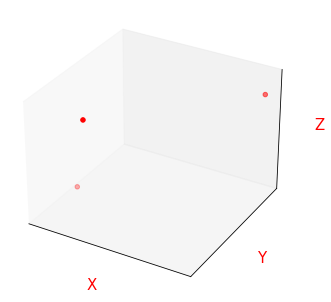

In [11]:
a.run(times=100,process_display=False,image_display=True)